# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [103]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

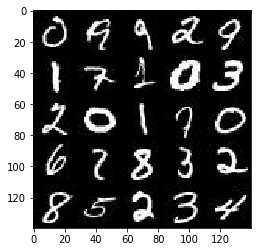

In [104]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

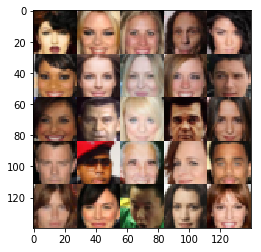

In [105]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [106]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [107]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input = tf.placeholder(shape=[None, image_width, image_height, image_channels], dtype=tf.float32)
    input_z = tf.placeholder(shape=[None, z_dim], dtype=tf.float32)
    learning_rate = tf.placeholder(dtype=tf.float32)
    
    return real_input, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [108]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """

    with tf.variable_scope('discriminator', reuse=reuse):
            
            alpha = 0.2
            # Input layer is 32x32x3
            x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
            #leaky relu
            relu1 = tf.maximum(alpha * x1, x1)
            # 16x16x64

            x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
            bn2 = tf.layers.batch_normalization(x2, training=True)
            relu2 = tf.maximum(alpha * bn2, bn2)
            # 8x8x128

            x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
            bn3 = tf.layers.batch_normalization(x3, training=True)
            relu3 = tf.maximum(alpha * bn3, bn3)
            # 4x4x256

            # Flatten it
            #flat = tf.reshape(relu3, (-1, 4*4*256))
            flat = tf.contrib.layers.flatten(relu3)
            logits = tf.layers.dense(flat, 1, activation=None)
            out = tf.sigmoid(logits)
            
            return out, logits




"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [109]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse= not is_train):
            alpha = 0.2
            # First fully connected layer
            x1 = tf.layers.dense(z, 7*7*512, activation=None)
            # Reshape it to start the convolutional stack
            x1 = tf.reshape(x1, (-1, 7, 7, 512))
            
            x1 = tf.layers.batch_normalization(x1, training=is_train)
            x1 = tf.maximum(alpha * x1, x1)
            #print(x1)
            # 7x7x512

            x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
            x2 = tf.layers.batch_normalization(x2, training=is_train)
            x2 = tf.maximum(alpha * x2, x2)
            
            x3 = tf.layers.conv2d_transpose(x2, 256, 5, strides=2, padding='same')
            x3 = tf.layers.batch_normalization(x3, training=is_train)
            x3 = tf.maximum(alpha * x3, x3)
            #print(x2)
            # 14x14x256

            logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same')        
            #print(logits)
            
            out = tf.tanh(logits)
            #expected 28 x 28 x out_channel_dim
            #print(out)

    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [110]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [111]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function

    # Get the trainable_variables, split into G and D parts
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    g_train_opt = tf.train.AdamOptimizer(learning_rate,beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [112]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [113]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    image_width = data_shape[1]
    image_height = data_shape[2]
    output_dim = data_shape[3]


    input_real, input_z, learn_rate = model_inputs(image_width, image_height, output_dim, z_dim)

    d_loss, g_loss = model_loss(input_real, input_z, output_dim)

    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            steps = 0
            for batch_images in get_batches(batch_size):
                # TODO: Train Model

                steps += 1

                #Rescaling images
                batch_images = batch_images*2

                # Random Noise for Generator
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Optimizing
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z, learn_rate: learning_rate})

                # Optimize Generator again 2nd
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z, learn_rate: learning_rate})

                # Optimize Generator again 3rd
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z, learn_rate: learning_rate})

                if steps % 10 == 0:
                    # Determine losses and print
                    d_train_loss = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    g_train_loss = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{} Batch# {}...".format(epoch_i+1, epoch_count, steps),
                          "Discriminator Loss: {:.4f}...".format(d_train_loss),
                          "Generator Loss: {:.4f}".format(g_train_loss))

                if steps % 100 == 0:
                    show_generator_output(sess, 25, input_z, output_dim, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

In [114]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

KeyboardInterrupt: 

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1 Batch# 10... Discriminator Loss: 4.5285... Generator Loss: 0.0341
Epoch 1/1 Batch# 20... Discriminator Loss: 3.0627... Generator Loss: 0.1365
Epoch 1/1 Batch# 30... Discriminator Loss: 3.2536... Generator Loss: 0.1273
Epoch 1/1 Batch# 40... Discriminator Loss: 2.8246... Generator Loss: 0.1598
Epoch 1/1 Batch# 50... Discriminator Loss: 1.8711... Generator Loss: 0.5371
Epoch 1/1 Batch# 60... Discriminator Loss: 1.7039... Generator Loss: 1.9373
Epoch 1/1 Batch# 70... Discriminator Loss: 2.1181... Generator Loss: 1.3102
Epoch 1/1 Batch# 80... Discriminator Loss: 2.3517... Generator Loss: 0.1778
Epoch 1/1 Batch# 90... Discriminator Loss: 2.3873... Generator Loss: 0.2098
Epoch 1/1 Batch# 100... Discriminator Loss: 1.9337... Generator Loss: 0.4339


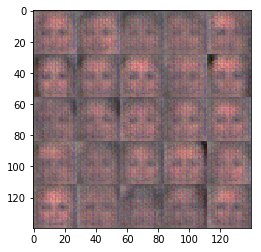

Epoch 1/1 Batch# 110... Discriminator Loss: 1.9621... Generator Loss: 0.3513
Epoch 1/1 Batch# 120... Discriminator Loss: 2.0549... Generator Loss: 0.3715
Epoch 1/1 Batch# 130... Discriminator Loss: 1.9095... Generator Loss: 0.3863
Epoch 1/1 Batch# 140... Discriminator Loss: 1.7967... Generator Loss: 0.5718
Epoch 1/1 Batch# 150... Discriminator Loss: 1.7793... Generator Loss: 0.4389
Epoch 1/1 Batch# 160... Discriminator Loss: 1.7767... Generator Loss: 0.4648
Epoch 1/1 Batch# 170... Discriminator Loss: 1.7694... Generator Loss: 0.4600
Epoch 1/1 Batch# 180... Discriminator Loss: 1.8513... Generator Loss: 0.4226
Epoch 1/1 Batch# 190... Discriminator Loss: 1.6732... Generator Loss: 0.5850
Epoch 1/1 Batch# 200... Discriminator Loss: 1.7974... Generator Loss: 0.5592


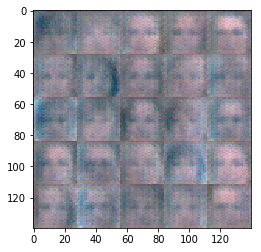

Epoch 1/1 Batch# 210... Discriminator Loss: 1.8544... Generator Loss: 0.4538
Epoch 1/1 Batch# 220... Discriminator Loss: 1.7020... Generator Loss: 0.4814
Epoch 1/1 Batch# 230... Discriminator Loss: 1.6110... Generator Loss: 0.6026
Epoch 1/1 Batch# 240... Discriminator Loss: 1.6088... Generator Loss: 0.5373
Epoch 1/1 Batch# 250... Discriminator Loss: 1.6245... Generator Loss: 0.5207
Epoch 1/1 Batch# 260... Discriminator Loss: 1.6916... Generator Loss: 0.4734
Epoch 1/1 Batch# 270... Discriminator Loss: 1.6846... Generator Loss: 0.5143
Epoch 1/1 Batch# 280... Discriminator Loss: 1.6050... Generator Loss: 0.5557
Epoch 1/1 Batch# 290... Discriminator Loss: 1.5753... Generator Loss: 0.5817
Epoch 1/1 Batch# 300... Discriminator Loss: 1.6740... Generator Loss: 0.4784


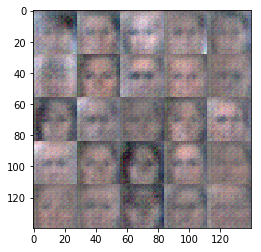

Epoch 1/1 Batch# 310... Discriminator Loss: 1.7516... Generator Loss: 0.5120
Epoch 1/1 Batch# 320... Discriminator Loss: 1.6522... Generator Loss: 0.5723
Epoch 1/1 Batch# 330... Discriminator Loss: 1.6936... Generator Loss: 0.5443
Epoch 1/1 Batch# 340... Discriminator Loss: 1.5460... Generator Loss: 0.5808
Epoch 1/1 Batch# 350... Discriminator Loss: 1.5644... Generator Loss: 0.6114
Epoch 1/1 Batch# 360... Discriminator Loss: 1.5611... Generator Loss: 0.5862
Epoch 1/1 Batch# 370... Discriminator Loss: 1.6999... Generator Loss: 0.5387
Epoch 1/1 Batch# 380... Discriminator Loss: 1.5004... Generator Loss: 0.5980
Epoch 1/1 Batch# 390... Discriminator Loss: 1.6357... Generator Loss: 0.5592
Epoch 1/1 Batch# 400... Discriminator Loss: 1.6728... Generator Loss: 0.5123


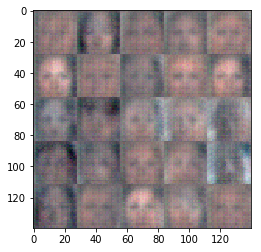

Epoch 1/1 Batch# 410... Discriminator Loss: 1.6411... Generator Loss: 0.5277
Epoch 1/1 Batch# 420... Discriminator Loss: 1.7287... Generator Loss: 0.5566
Epoch 1/1 Batch# 430... Discriminator Loss: 1.5994... Generator Loss: 0.5787
Epoch 1/1 Batch# 440... Discriminator Loss: 1.5436... Generator Loss: 0.5833
Epoch 1/1 Batch# 450... Discriminator Loss: 1.5392... Generator Loss: 0.5944
Epoch 1/1 Batch# 460... Discriminator Loss: 1.5725... Generator Loss: 0.5525
Epoch 1/1 Batch# 470... Discriminator Loss: 1.4948... Generator Loss: 0.6274
Epoch 1/1 Batch# 480... Discriminator Loss: 1.5493... Generator Loss: 0.5987
Epoch 1/1 Batch# 490... Discriminator Loss: 1.5167... Generator Loss: 0.6398
Epoch 1/1 Batch# 500... Discriminator Loss: 1.4912... Generator Loss: 0.5977


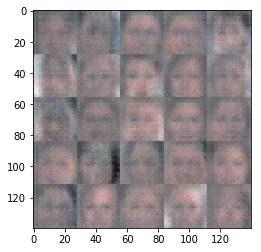

Epoch 1/1 Batch# 510... Discriminator Loss: 1.4856... Generator Loss: 0.6245
Epoch 1/1 Batch# 520... Discriminator Loss: 1.5218... Generator Loss: 0.6292
Epoch 1/1 Batch# 530... Discriminator Loss: 1.5599... Generator Loss: 0.5581
Epoch 1/1 Batch# 540... Discriminator Loss: 1.5291... Generator Loss: 0.5894
Epoch 1/1 Batch# 550... Discriminator Loss: 1.4738... Generator Loss: 0.6510
Epoch 1/1 Batch# 560... Discriminator Loss: 1.5211... Generator Loss: 0.6365
Epoch 1/1 Batch# 570... Discriminator Loss: 1.5041... Generator Loss: 0.6369
Epoch 1/1 Batch# 580... Discriminator Loss: 1.4708... Generator Loss: 0.6353
Epoch 1/1 Batch# 590... Discriminator Loss: 1.4604... Generator Loss: 0.6079
Epoch 1/1 Batch# 600... Discriminator Loss: 1.4683... Generator Loss: 0.6147


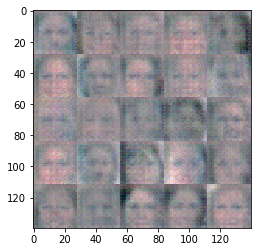

Epoch 1/1 Batch# 610... Discriminator Loss: 1.4855... Generator Loss: 0.6819
Epoch 1/1 Batch# 620... Discriminator Loss: 1.6201... Generator Loss: 0.5334
Epoch 1/1 Batch# 630... Discriminator Loss: 1.5230... Generator Loss: 0.6508
Epoch 1/1 Batch# 640... Discriminator Loss: 1.4771... Generator Loss: 0.6210
Epoch 1/1 Batch# 650... Discriminator Loss: 1.5681... Generator Loss: 0.5707
Epoch 1/1 Batch# 660... Discriminator Loss: 1.5863... Generator Loss: 0.5423
Epoch 1/1 Batch# 670... Discriminator Loss: 1.4832... Generator Loss: 0.6622
Epoch 1/1 Batch# 680... Discriminator Loss: 1.4576... Generator Loss: 0.6531
Epoch 1/1 Batch# 690... Discriminator Loss: 1.5466... Generator Loss: 0.6036
Epoch 1/1 Batch# 700... Discriminator Loss: 1.4809... Generator Loss: 0.5847


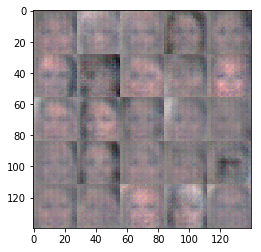

Epoch 1/1 Batch# 710... Discriminator Loss: 1.5587... Generator Loss: 0.6379
Epoch 1/1 Batch# 720... Discriminator Loss: 1.5357... Generator Loss: 0.6250
Epoch 1/1 Batch# 730... Discriminator Loss: 1.4801... Generator Loss: 0.6973
Epoch 1/1 Batch# 740... Discriminator Loss: 1.4578... Generator Loss: 0.6481
Epoch 1/1 Batch# 750... Discriminator Loss: 1.4550... Generator Loss: 0.6523
Epoch 1/1 Batch# 760... Discriminator Loss: 1.5355... Generator Loss: 0.6349
Epoch 1/1 Batch# 770... Discriminator Loss: 1.4169... Generator Loss: 0.6765
Epoch 1/1 Batch# 780... Discriminator Loss: 1.5868... Generator Loss: 0.6742
Epoch 1/1 Batch# 790... Discriminator Loss: 1.6078... Generator Loss: 0.5535
Epoch 1/1 Batch# 800... Discriminator Loss: 1.5780... Generator Loss: 0.5556


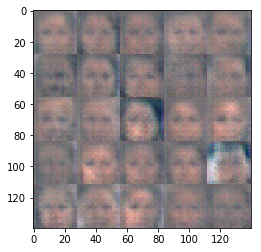

Epoch 1/1 Batch# 810... Discriminator Loss: 1.6031... Generator Loss: 0.5605
Epoch 1/1 Batch# 820... Discriminator Loss: 1.5297... Generator Loss: 0.5597
Epoch 1/1 Batch# 830... Discriminator Loss: 1.4963... Generator Loss: 0.5607
Epoch 1/1 Batch# 840... Discriminator Loss: 1.4936... Generator Loss: 0.6017
Epoch 1/1 Batch# 850... Discriminator Loss: 1.4417... Generator Loss: 0.6629
Epoch 1/1 Batch# 860... Discriminator Loss: 1.4493... Generator Loss: 0.6342
Epoch 1/1 Batch# 870... Discriminator Loss: 1.5056... Generator Loss: 0.5921
Epoch 1/1 Batch# 880... Discriminator Loss: 1.5071... Generator Loss: 0.6345
Epoch 1/1 Batch# 890... Discriminator Loss: 1.5419... Generator Loss: 0.6277
Epoch 1/1 Batch# 900... Discriminator Loss: 1.5180... Generator Loss: 0.6063


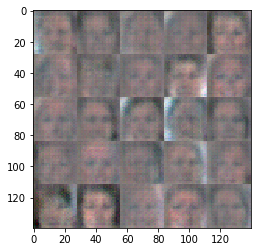

Epoch 1/1 Batch# 910... Discriminator Loss: 1.4702... Generator Loss: 0.6683
Epoch 1/1 Batch# 920... Discriminator Loss: 1.4291... Generator Loss: 0.6553
Epoch 1/1 Batch# 930... Discriminator Loss: 1.4472... Generator Loss: 0.6183
Epoch 1/1 Batch# 940... Discriminator Loss: 1.4819... Generator Loss: 0.6134
Epoch 1/1 Batch# 950... Discriminator Loss: 1.4985... Generator Loss: 0.6161
Epoch 1/1 Batch# 960... Discriminator Loss: 1.4466... Generator Loss: 0.6193
Epoch 1/1 Batch# 970... Discriminator Loss: 1.4791... Generator Loss: 0.6075
Epoch 1/1 Batch# 980... Discriminator Loss: 1.5097... Generator Loss: 0.6543
Epoch 1/1 Batch# 990... Discriminator Loss: 1.4309... Generator Loss: 0.6401
Epoch 1/1 Batch# 1000... Discriminator Loss: 1.4984... Generator Loss: 0.5845


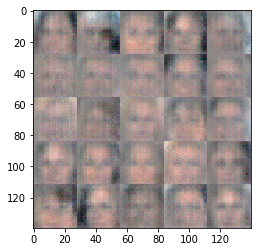

Epoch 1/1 Batch# 1010... Discriminator Loss: 1.4207... Generator Loss: 0.6936
Epoch 1/1 Batch# 1020... Discriminator Loss: 1.4600... Generator Loss: 0.6848
Epoch 1/1 Batch# 1030... Discriminator Loss: 1.5324... Generator Loss: 0.5697
Epoch 1/1 Batch# 1040... Discriminator Loss: 1.4310... Generator Loss: 0.6804
Epoch 1/1 Batch# 1050... Discriminator Loss: 1.4447... Generator Loss: 0.6579
Epoch 1/1 Batch# 1060... Discriminator Loss: 1.4748... Generator Loss: 0.6042
Epoch 1/1 Batch# 1070... Discriminator Loss: 1.4222... Generator Loss: 0.7239
Epoch 1/1 Batch# 1080... Discriminator Loss: 1.5253... Generator Loss: 0.6079
Epoch 1/1 Batch# 1090... Discriminator Loss: 1.5484... Generator Loss: 0.5788
Epoch 1/1 Batch# 1100... Discriminator Loss: 1.4160... Generator Loss: 0.6610


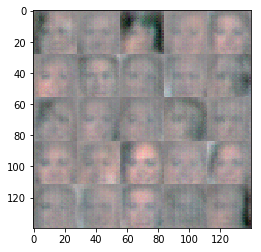

Epoch 1/1 Batch# 1110... Discriminator Loss: 1.4764... Generator Loss: 0.5982
Epoch 1/1 Batch# 1120... Discriminator Loss: 1.4976... Generator Loss: 0.6418
Epoch 1/1 Batch# 1130... Discriminator Loss: 1.6072... Generator Loss: 0.4996
Epoch 1/1 Batch# 1140... Discriminator Loss: 1.5651... Generator Loss: 0.5624
Epoch 1/1 Batch# 1150... Discriminator Loss: 1.6271... Generator Loss: 0.5695
Epoch 1/1 Batch# 1160... Discriminator Loss: 1.4655... Generator Loss: 0.6589
Epoch 1/1 Batch# 1170... Discriminator Loss: 1.4246... Generator Loss: 0.6149
Epoch 1/1 Batch# 1180... Discriminator Loss: 1.4185... Generator Loss: 0.6605
Epoch 1/1 Batch# 1190... Discriminator Loss: 1.4184... Generator Loss: 0.6671
Epoch 1/1 Batch# 1200... Discriminator Loss: 1.4299... Generator Loss: 0.6853


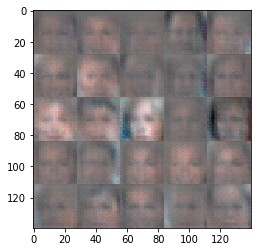

Epoch 1/1 Batch# 1210... Discriminator Loss: 1.4750... Generator Loss: 0.6460
Epoch 1/1 Batch# 1220... Discriminator Loss: 1.4495... Generator Loss: 0.6603
Epoch 1/1 Batch# 1230... Discriminator Loss: 1.4334... Generator Loss: 0.6245
Epoch 1/1 Batch# 1240... Discriminator Loss: 1.4418... Generator Loss: 0.6736
Epoch 1/1 Batch# 1250... Discriminator Loss: 1.4827... Generator Loss: 0.6539
Epoch 1/1 Batch# 1260... Discriminator Loss: 1.4716... Generator Loss: 0.6321
Epoch 1/1 Batch# 1270... Discriminator Loss: 1.4359... Generator Loss: 0.6192
Epoch 1/1 Batch# 1280... Discriminator Loss: 1.4437... Generator Loss: 0.6570
Epoch 1/1 Batch# 1290... Discriminator Loss: 1.4499... Generator Loss: 0.6513
Epoch 1/1 Batch# 1300... Discriminator Loss: 1.4777... Generator Loss: 0.6045


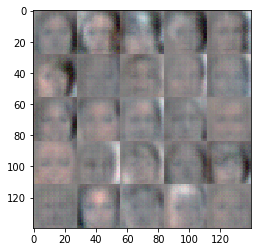

Epoch 1/1 Batch# 1310... Discriminator Loss: 1.4171... Generator Loss: 0.6311
Epoch 1/1 Batch# 1320... Discriminator Loss: 1.4302... Generator Loss: 0.6689
Epoch 1/1 Batch# 1330... Discriminator Loss: 1.4278... Generator Loss: 0.6621
Epoch 1/1 Batch# 1340... Discriminator Loss: 1.4421... Generator Loss: 0.6885
Epoch 1/1 Batch# 1350... Discriminator Loss: 1.4137... Generator Loss: 0.6453
Epoch 1/1 Batch# 1360... Discriminator Loss: 1.4331... Generator Loss: 0.6960
Epoch 1/1 Batch# 1370... Discriminator Loss: 1.4841... Generator Loss: 0.6430
Epoch 1/1 Batch# 1380... Discriminator Loss: 1.4681... Generator Loss: 0.6517
Epoch 1/1 Batch# 1390... Discriminator Loss: 1.4215... Generator Loss: 0.6681
Epoch 1/1 Batch# 1400... Discriminator Loss: 1.4374... Generator Loss: 0.6519


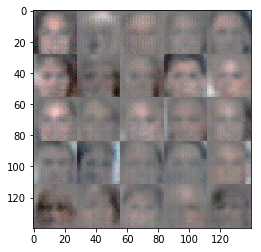

Epoch 1/1 Batch# 1410... Discriminator Loss: 1.4735... Generator Loss: 0.6162
Epoch 1/1 Batch# 1420... Discriminator Loss: 1.4495... Generator Loss: 0.6577
Epoch 1/1 Batch# 1430... Discriminator Loss: 1.4228... Generator Loss: 0.6600
Epoch 1/1 Batch# 1440... Discriminator Loss: 1.3955... Generator Loss: 0.7030
Epoch 1/1 Batch# 1450... Discriminator Loss: 1.4260... Generator Loss: 0.6347
Epoch 1/1 Batch# 1460... Discriminator Loss: 1.4419... Generator Loss: 0.6431
Epoch 1/1 Batch# 1470... Discriminator Loss: 1.4369... Generator Loss: 0.6106
Epoch 1/1 Batch# 1480... Discriminator Loss: 1.5221... Generator Loss: 0.6001
Epoch 1/1 Batch# 1490... Discriminator Loss: 1.4609... Generator Loss: 0.6281
Epoch 1/1 Batch# 1500... Discriminator Loss: 1.4368... Generator Loss: 0.6562


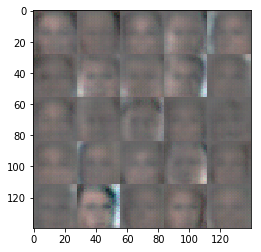

Epoch 1/1 Batch# 1510... Discriminator Loss: 1.4375... Generator Loss: 0.6562
Epoch 1/1 Batch# 1520... Discriminator Loss: 1.4395... Generator Loss: 0.6310
Epoch 1/1 Batch# 1530... Discriminator Loss: 1.4222... Generator Loss: 0.6598
Epoch 1/1 Batch# 1540... Discriminator Loss: 1.4175... Generator Loss: 0.6575
Epoch 1/1 Batch# 1550... Discriminator Loss: 1.4175... Generator Loss: 0.6696
Epoch 1/1 Batch# 1560... Discriminator Loss: 1.4878... Generator Loss: 0.5737
Epoch 1/1 Batch# 1570... Discriminator Loss: 1.5008... Generator Loss: 0.6070
Epoch 1/1 Batch# 1580... Discriminator Loss: 1.4037... Generator Loss: 0.7009
Epoch 1/1 Batch# 1590... Discriminator Loss: 1.4493... Generator Loss: 0.6023
Epoch 1/1 Batch# 1600... Discriminator Loss: 1.4847... Generator Loss: 0.6273


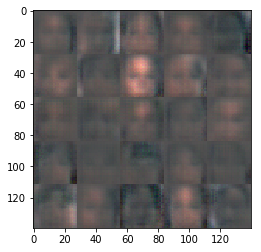

Epoch 1/1 Batch# 1610... Discriminator Loss: 1.4635... Generator Loss: 0.6405
Epoch 1/1 Batch# 1620... Discriminator Loss: 1.4278... Generator Loss: 0.6695
Epoch 1/1 Batch# 1630... Discriminator Loss: 1.4654... Generator Loss: 0.6162
Epoch 1/1 Batch# 1640... Discriminator Loss: 1.4846... Generator Loss: 0.5632
Epoch 1/1 Batch# 1650... Discriminator Loss: 1.4633... Generator Loss: 0.6382
Epoch 1/1 Batch# 1660... Discriminator Loss: 1.5335... Generator Loss: 0.5543
Epoch 1/1 Batch# 1670... Discriminator Loss: 1.4670... Generator Loss: 0.6386
Epoch 1/1 Batch# 1680... Discriminator Loss: 1.4578... Generator Loss: 0.6866
Epoch 1/1 Batch# 1690... Discriminator Loss: 1.4385... Generator Loss: 0.6749
Epoch 1/1 Batch# 1700... Discriminator Loss: 1.4341... Generator Loss: 0.6197


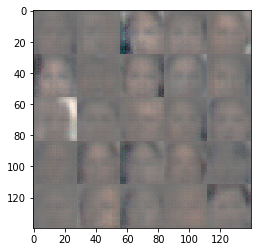

Epoch 1/1 Batch# 1710... Discriminator Loss: 1.4509... Generator Loss: 0.6144
Epoch 1/1 Batch# 1720... Discriminator Loss: 1.4488... Generator Loss: 0.6453
Epoch 1/1 Batch# 1730... Discriminator Loss: 1.5299... Generator Loss: 0.6113
Epoch 1/1 Batch# 1740... Discriminator Loss: 1.4395... Generator Loss: 0.6992
Epoch 1/1 Batch# 1750... Discriminator Loss: 1.4468... Generator Loss: 0.6569
Epoch 1/1 Batch# 1760... Discriminator Loss: 1.4652... Generator Loss: 0.6796
Epoch 1/1 Batch# 1770... Discriminator Loss: 1.4396... Generator Loss: 0.6021
Epoch 1/1 Batch# 1780... Discriminator Loss: 1.4347... Generator Loss: 0.6801
Epoch 1/1 Batch# 1790... Discriminator Loss: 1.4411... Generator Loss: 0.6209
Epoch 1/1 Batch# 1800... Discriminator Loss: 1.4581... Generator Loss: 0.6284


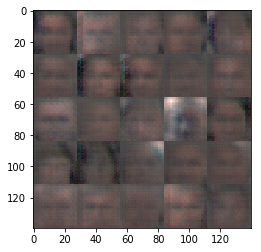

Epoch 1/1 Batch# 1810... Discriminator Loss: 1.4834... Generator Loss: 0.6364
Epoch 1/1 Batch# 1820... Discriminator Loss: 1.5531... Generator Loss: 0.6057
Epoch 1/1 Batch# 1830... Discriminator Loss: 1.4524... Generator Loss: 0.6562
Epoch 1/1 Batch# 1840... Discriminator Loss: 1.4586... Generator Loss: 0.6237
Epoch 1/1 Batch# 1850... Discriminator Loss: 1.4201... Generator Loss: 0.7804
Epoch 1/1 Batch# 1860... Discriminator Loss: 1.4771... Generator Loss: 0.6268
Epoch 1/1 Batch# 1870... Discriminator Loss: 1.4354... Generator Loss: 0.6193
Epoch 1/1 Batch# 1880... Discriminator Loss: 1.4329... Generator Loss: 0.6357
Epoch 1/1 Batch# 1890... Discriminator Loss: 1.4372... Generator Loss: 0.6704
Epoch 1/1 Batch# 1900... Discriminator Loss: 1.4289... Generator Loss: 0.6487


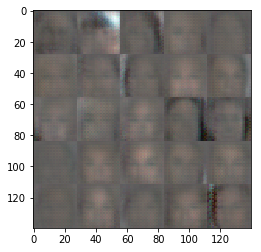

Epoch 1/1 Batch# 1910... Discriminator Loss: 1.4559... Generator Loss: 0.6632
Epoch 1/1 Batch# 1920... Discriminator Loss: 1.4700... Generator Loss: 0.6464
Epoch 1/1 Batch# 1930... Discriminator Loss: 1.4683... Generator Loss: 0.6298
Epoch 1/1 Batch# 1940... Discriminator Loss: 1.4918... Generator Loss: 0.6573
Epoch 1/1 Batch# 1950... Discriminator Loss: 1.4640... Generator Loss: 0.6417
Epoch 1/1 Batch# 1960... Discriminator Loss: 1.4877... Generator Loss: 0.6182
Epoch 1/1 Batch# 1970... Discriminator Loss: 1.4949... Generator Loss: 0.6868
Epoch 1/1 Batch# 1980... Discriminator Loss: 1.4876... Generator Loss: 0.6637
Epoch 1/1 Batch# 1990... Discriminator Loss: 1.5134... Generator Loss: 0.6050
Epoch 1/1 Batch# 2000... Discriminator Loss: 1.4697... Generator Loss: 0.6223


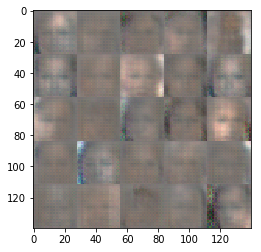

Epoch 1/1 Batch# 2010... Discriminator Loss: 1.5121... Generator Loss: 0.6068
Epoch 1/1 Batch# 2020... Discriminator Loss: 1.4553... Generator Loss: 0.6831
Epoch 1/1 Batch# 2030... Discriminator Loss: 1.4341... Generator Loss: 0.7023
Epoch 1/1 Batch# 2040... Discriminator Loss: 1.4958... Generator Loss: 0.6165
Epoch 1/1 Batch# 2050... Discriminator Loss: 1.4506... Generator Loss: 0.5633
Epoch 1/1 Batch# 2060... Discriminator Loss: 1.4484... Generator Loss: 0.6205
Epoch 1/1 Batch# 2070... Discriminator Loss: 1.3868... Generator Loss: 0.6803
Epoch 1/1 Batch# 2080... Discriminator Loss: 1.4304... Generator Loss: 0.6417
Epoch 1/1 Batch# 2090... Discriminator Loss: 1.4741... Generator Loss: 0.6136
Epoch 1/1 Batch# 2100... Discriminator Loss: 1.4612... Generator Loss: 0.6148


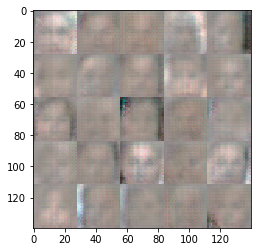

Epoch 1/1 Batch# 2110... Discriminator Loss: 1.4400... Generator Loss: 0.7049
Epoch 1/1 Batch# 2120... Discriminator Loss: 1.4765... Generator Loss: 0.6203
Epoch 1/1 Batch# 2130... Discriminator Loss: 1.5274... Generator Loss: 0.5527
Epoch 1/1 Batch# 2140... Discriminator Loss: 1.5058... Generator Loss: 0.6083
Epoch 1/1 Batch# 2150... Discriminator Loss: 1.4203... Generator Loss: 0.6656
Epoch 1/1 Batch# 2160... Discriminator Loss: 1.4340... Generator Loss: 0.6260
Epoch 1/1 Batch# 2170... Discriminator Loss: 1.4168... Generator Loss: 0.7188
Epoch 1/1 Batch# 2180... Discriminator Loss: 1.4362... Generator Loss: 0.6663
Epoch 1/1 Batch# 2190... Discriminator Loss: 1.4241... Generator Loss: 0.6992
Epoch 1/1 Batch# 2200... Discriminator Loss: 1.4450... Generator Loss: 0.6093


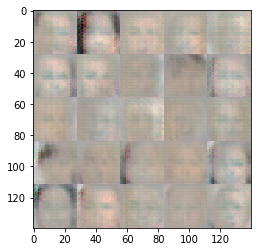

Epoch 1/1 Batch# 2210... Discriminator Loss: 1.4237... Generator Loss: 0.6498
Epoch 1/1 Batch# 2220... Discriminator Loss: 1.4459... Generator Loss: 0.6516
Epoch 1/1 Batch# 2230... Discriminator Loss: 1.4559... Generator Loss: 0.6257
Epoch 1/1 Batch# 2240... Discriminator Loss: 1.4252... Generator Loss: 0.6550
Epoch 1/1 Batch# 2250... Discriminator Loss: 1.4269... Generator Loss: 0.6623
Epoch 1/1 Batch# 2260... Discriminator Loss: 1.4655... Generator Loss: 0.6735
Epoch 1/1 Batch# 2270... Discriminator Loss: 1.4572... Generator Loss: 0.6189
Epoch 1/1 Batch# 2280... Discriminator Loss: 1.5084... Generator Loss: 0.5699
Epoch 1/1 Batch# 2290... Discriminator Loss: 1.4287... Generator Loss: 0.6485
Epoch 1/1 Batch# 2300... Discriminator Loss: 1.4628... Generator Loss: 0.6559


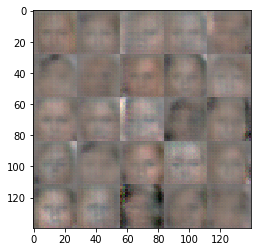

Epoch 1/1 Batch# 2310... Discriminator Loss: 1.4493... Generator Loss: 0.6238
Epoch 1/1 Batch# 2320... Discriminator Loss: 1.4656... Generator Loss: 0.6312
Epoch 1/1 Batch# 2330... Discriminator Loss: 1.4662... Generator Loss: 0.5993
Epoch 1/1 Batch# 2340... Discriminator Loss: 1.5126... Generator Loss: 0.6018
Epoch 1/1 Batch# 2350... Discriminator Loss: 1.4670... Generator Loss: 0.5963
Epoch 1/1 Batch# 2360... Discriminator Loss: 1.4406... Generator Loss: 0.6572
Epoch 1/1 Batch# 2370... Discriminator Loss: 1.5031... Generator Loss: 0.5361
Epoch 1/1 Batch# 2380... Discriminator Loss: 1.4495... Generator Loss: 0.6434
Epoch 1/1 Batch# 2390... Discriminator Loss: 1.4533... Generator Loss: 0.6909
Epoch 1/1 Batch# 2400... Discriminator Loss: 1.5088... Generator Loss: 0.6099


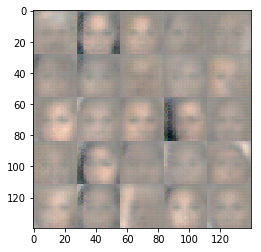

Epoch 1/1 Batch# 2410... Discriminator Loss: 1.4433... Generator Loss: 0.6160
Epoch 1/1 Batch# 2420... Discriminator Loss: 1.4512... Generator Loss: 0.6734
Epoch 1/1 Batch# 2430... Discriminator Loss: 1.4375... Generator Loss: 0.6511
Epoch 1/1 Batch# 2440... Discriminator Loss: 1.4700... Generator Loss: 0.6281
Epoch 1/1 Batch# 2450... Discriminator Loss: 1.4206... Generator Loss: 0.6226
Epoch 1/1 Batch# 2460... Discriminator Loss: 1.4298... Generator Loss: 0.6554
Epoch 1/1 Batch# 2470... Discriminator Loss: 1.4459... Generator Loss: 0.6158
Epoch 1/1 Batch# 2480... Discriminator Loss: 1.4351... Generator Loss: 0.6310
Epoch 1/1 Batch# 2490... Discriminator Loss: 1.5761... Generator Loss: 0.5134
Epoch 1/1 Batch# 2500... Discriminator Loss: 1.4492... Generator Loss: 0.6427


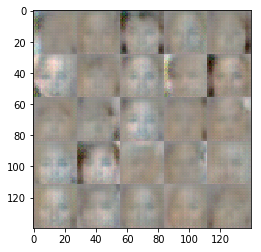

Epoch 1/1 Batch# 2510... Discriminator Loss: 1.4506... Generator Loss: 0.6828
Epoch 1/1 Batch# 2520... Discriminator Loss: 1.4972... Generator Loss: 0.6079
Epoch 1/1 Batch# 2530... Discriminator Loss: 1.4279... Generator Loss: 0.6577
Epoch 1/1 Batch# 2540... Discriminator Loss: 1.4264... Generator Loss: 0.6795
Epoch 1/1 Batch# 2550... Discriminator Loss: 1.4497... Generator Loss: 0.6341
Epoch 1/1 Batch# 2560... Discriminator Loss: 1.4237... Generator Loss: 0.6476
Epoch 1/1 Batch# 2570... Discriminator Loss: 1.4301... Generator Loss: 0.7017
Epoch 1/1 Batch# 2580... Discriminator Loss: 1.4287... Generator Loss: 0.6718
Epoch 1/1 Batch# 2590... Discriminator Loss: 1.4337... Generator Loss: 0.6982
Epoch 1/1 Batch# 2600... Discriminator Loss: 1.4210... Generator Loss: 0.6500


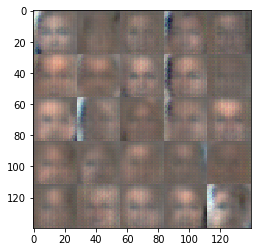

Epoch 1/1 Batch# 2610... Discriminator Loss: 1.4499... Generator Loss: 0.6624
Epoch 1/1 Batch# 2620... Discriminator Loss: 1.4519... Generator Loss: 0.6624
Epoch 1/1 Batch# 2630... Discriminator Loss: 1.4244... Generator Loss: 0.6506
Epoch 1/1 Batch# 2640... Discriminator Loss: 1.4279... Generator Loss: 0.6374
Epoch 1/1 Batch# 2650... Discriminator Loss: 1.4531... Generator Loss: 0.6490
Epoch 1/1 Batch# 2660... Discriminator Loss: 1.4412... Generator Loss: 0.6384
Epoch 1/1 Batch# 2670... Discriminator Loss: 1.4352... Generator Loss: 0.6761
Epoch 1/1 Batch# 2680... Discriminator Loss: 1.4488... Generator Loss: 0.6652
Epoch 1/1 Batch# 2690... Discriminator Loss: 1.4510... Generator Loss: 0.7084
Epoch 1/1 Batch# 2700... Discriminator Loss: 1.4218... Generator Loss: 0.6493


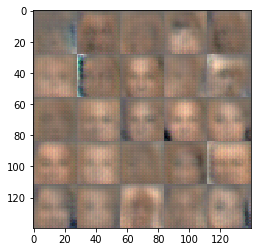

Epoch 1/1 Batch# 2710... Discriminator Loss: 1.4617... Generator Loss: 0.6244
Epoch 1/1 Batch# 2720... Discriminator Loss: 1.4335... Generator Loss: 0.6287
Epoch 1/1 Batch# 2730... Discriminator Loss: 1.4577... Generator Loss: 0.6287
Epoch 1/1 Batch# 2740... Discriminator Loss: 1.4308... Generator Loss: 0.6425
Epoch 1/1 Batch# 2750... Discriminator Loss: 1.4204... Generator Loss: 0.6653
Epoch 1/1 Batch# 2760... Discriminator Loss: 1.4432... Generator Loss: 0.6450
Epoch 1/1 Batch# 2770... Discriminator Loss: 1.4792... Generator Loss: 0.6504
Epoch 1/1 Batch# 2780... Discriminator Loss: 1.4277... Generator Loss: 0.6335
Epoch 1/1 Batch# 2790... Discriminator Loss: 1.4663... Generator Loss: 0.6599
Epoch 1/1 Batch# 2800... Discriminator Loss: 1.5750... Generator Loss: 0.5206


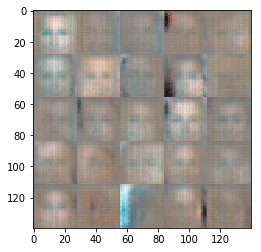

Epoch 1/1 Batch# 2810... Discriminator Loss: 1.5138... Generator Loss: 0.6350
Epoch 1/1 Batch# 2820... Discriminator Loss: 1.4371... Generator Loss: 0.6210
Epoch 1/1 Batch# 2830... Discriminator Loss: 1.4623... Generator Loss: 0.6356
Epoch 1/1 Batch# 2840... Discriminator Loss: 1.4875... Generator Loss: 0.6116
Epoch 1/1 Batch# 2850... Discriminator Loss: 1.4876... Generator Loss: 0.6265
Epoch 1/1 Batch# 2860... Discriminator Loss: 1.4515... Generator Loss: 0.6341
Epoch 1/1 Batch# 2870... Discriminator Loss: 1.4530... Generator Loss: 0.6727
Epoch 1/1 Batch# 2880... Discriminator Loss: 1.4496... Generator Loss: 0.6491
Epoch 1/1 Batch# 2890... Discriminator Loss: 1.4385... Generator Loss: 0.6231
Epoch 1/1 Batch# 2900... Discriminator Loss: 1.4626... Generator Loss: 0.6223


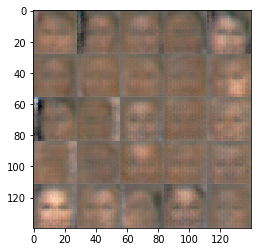

Epoch 1/1 Batch# 2910... Discriminator Loss: 1.4207... Generator Loss: 0.6890
Epoch 1/1 Batch# 2920... Discriminator Loss: 1.4459... Generator Loss: 0.6800
Epoch 1/1 Batch# 2930... Discriminator Loss: 1.4475... Generator Loss: 0.6314
Epoch 1/1 Batch# 2940... Discriminator Loss: 1.4375... Generator Loss: 0.6692
Epoch 1/1 Batch# 2950... Discriminator Loss: 1.4179... Generator Loss: 0.6257
Epoch 1/1 Batch# 2960... Discriminator Loss: 1.4230... Generator Loss: 0.6834
Epoch 1/1 Batch# 2970... Discriminator Loss: 1.3940... Generator Loss: 0.6574
Epoch 1/1 Batch# 2980... Discriminator Loss: 1.4041... Generator Loss: 0.6466
Epoch 1/1 Batch# 2990... Discriminator Loss: 1.4646... Generator Loss: 0.6597
Epoch 1/1 Batch# 3000... Discriminator Loss: 1.4381... Generator Loss: 0.6341


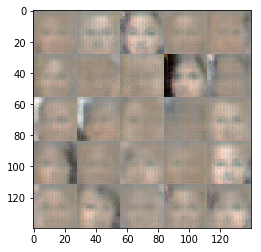

Epoch 1/1 Batch# 3010... Discriminator Loss: 1.4311... Generator Loss: 0.6545
Epoch 1/1 Batch# 3020... Discriminator Loss: 1.4533... Generator Loss: 0.6466
Epoch 1/1 Batch# 3030... Discriminator Loss: 1.4387... Generator Loss: 0.6271
Epoch 1/1 Batch# 3040... Discriminator Loss: 1.3954... Generator Loss: 0.6823
Epoch 1/1 Batch# 3050... Discriminator Loss: 1.4418... Generator Loss: 0.6917
Epoch 1/1 Batch# 3060... Discriminator Loss: 1.4525... Generator Loss: 0.6820
Epoch 1/1 Batch# 3070... Discriminator Loss: 1.4139... Generator Loss: 0.6758
Epoch 1/1 Batch# 3080... Discriminator Loss: 1.4212... Generator Loss: 0.6507
Epoch 1/1 Batch# 3090... Discriminator Loss: 1.4344... Generator Loss: 0.6398
Epoch 1/1 Batch# 3100... Discriminator Loss: 1.4707... Generator Loss: 0.6322


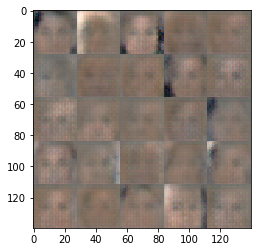

Epoch 1/1 Batch# 3110... Discriminator Loss: 1.4306... Generator Loss: 0.6613
Epoch 1/1 Batch# 3120... Discriminator Loss: 1.4289... Generator Loss: 0.6486
Epoch 1/1 Batch# 3130... Discriminator Loss: 1.4541... Generator Loss: 0.6244
Epoch 1/1 Batch# 3140... Discriminator Loss: 1.5142... Generator Loss: 0.7011
Epoch 1/1 Batch# 3150... Discriminator Loss: 1.4856... Generator Loss: 0.6097
Epoch 1/1 Batch# 3160... Discriminator Loss: 1.4531... Generator Loss: 0.6782


In [115]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.